In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d 'sriramr/fruits-fresh-and-rotten-for-classification'

100% 3.58G/3.58G [02:44<00:00, 23.9MB/s]
100% 3.58G/3.58G [02:44<00:00, 23.4MB/s]


In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import tensorflow_hub as hub

In [ ]:
dataset_zip = zipfile.ZipFile('fruits-fresh-and-rotten-for-classification.zip', 'r')
dataset_zip.extractall()
dataset_zip.close()

In [ ]:
dataset_dir='dataset'
train_dir = 'dataset/train/'
validation_dir = 'dataset/test/'

training_fresh_apples_dir = os.path.join(train_dir, 'freshapples/')
training_fresh_banana_dir = os.path.join(train_dir, 'freshbanana/')
training_fresh_oranges_dir = os.path.join(train_dir, 'freshoranges/')
training_rotten_apples_dir = os.path.join(train_dir, 'rottenapples/')
training_rotten_banana_dir = os.path.join(train_dir, 'rottenbanana/')
training_rotten_oranges_dir = os.path.join(train_dir, 'rottenoranges/')

validation_fresh_apples_dir = os.path.join(validation_dir, 'freshapples/')
validation_fresh_banana_dir = os.path.join(validation_dir, 'freshbanana/')
validation_fresh_oranges_dir = os.path.join(validation_dir, 'freshoranges/')
validation_rotten_apples_dir = os.path.join(validation_dir, 'rottenapples/')
validation_rotten_banana_dir = os.path.join(validation_dir, 'rottenbanana/')
validation_rotten_oranges_dir = os.path.join(validation_dir, 'rottenoranges/')

In [ ]:
print("TRAINING DATA SET")

print(f"There are {len(os.listdir(training_fresh_apples_dir))} images of fresh apples for training")
print(f"There are {len(os.listdir(training_fresh_banana_dir))} images of fresh banana for training")
print(f"There are {len(os.listdir(training_fresh_oranges_dir))} images of fresh oranges for training")
print(f"There are {len(os.listdir(training_rotten_apples_dir))} images of rotten apples for training")
print(f"There are {len(os.listdir(training_rotten_banana_dir))} images of rotten banana for training")
print(f"There are {len(os.listdir(training_rotten_oranges_dir))} images of rotten oranges for training")

print("\nVALIDATION DATA SET \n")
print(f"There are {len(os.listdir(validation_fresh_apples_dir))} images of fresh apples for validation")
print(f"There are {len(os.listdir(validation_fresh_banana_dir))} images of fresh banana for validation")
print(f"There are {len(os.listdir(validation_fresh_oranges_dir))} images of fresh oranges for validation")

print(f"There are {len(os.listdir(validation_rotten_apples_dir))} images of rotten apples for validation")
print(f"There are {len(os.listdir(validation_rotten_banana_dir))} images of rotten banana for validation")
print(f"There are {len(os.listdir(validation_rotten_oranges_dir))} images of rotten oranges for validation")

TRAINING DATA SET
There are 1693 images of fresh apples for training
There are 1581 images of fresh banana for training
There are 1466 images of fresh oranges for training
There are 2342 images of rotten apples for training
There are 2224 images of rotten banana for training
There are 1595 images of rotten oranges for training

VALIDATION DATA SET 

There are 395 images of fresh apples for validation
There are 381 images of fresh banana for validation
There are 388 images of fresh oranges for validation
There are 601 images of rotten apples for validation
There are 530 images of rotten banana for validation
There are 403 images of rotten oranges for validation


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(244, 244))

  validation_datagen = ImageDataGenerator(rescale=1/255)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(244, 244))

  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [ ]:
labels = train_generator.class_indices
train_generator.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

In [ ]:
validation_generator.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

In [ ]:
def create_model():

  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(244, 244, 3)),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(6, activation='softmax')
  ])

  from tensorflow.keras.optimizers import RMSprop
  model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 

  return model

In [ ]:
model = create_model()

history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
341/341 [==============================] - 199s 550ms/step - loss: 1.0637 - accuracy: 0.6292 - val_loss: 0.4543 - val_accuracy: 0.8369
Epoch 2/15
341/341 [==============================] - 186s 545ms/step - loss: 0.5372 - accuracy: 0.8057 - val_loss: 0.3732 - val_accuracy: 0.8595
Epoch 3/15
341/341 [==============================] - 182s 535ms/step - loss: 0.4221 - accuracy: 0.8484 - val_loss: 0.2848 - val_accuracy: 0.9007
Epoch 4/15
341/341 [==============================] - 185s 542ms/step - loss: 0.3606 - accuracy: 0.8681 - val_loss: 0.2247 - val_accuracy: 0.9136
Epoch 5/15
341/341 [==============================] - 184s 538ms/step - loss: 0.3106 - accuracy: 0.8874 - val_loss: 0.3033 - val_accuracy: 0.8881
Epoch 6/15
341/341 [==============================] - 187s 549ms/step - loss: 0.2750 - accuracy: 0.8984 - val_loss: 0.1700 - val_accuracy: 0.9292
Epoch 7/15
341/341 [==============================] - 186s 546ms/step - loss: 0.2576 - accuracy: 0.9032 - val_loss: 0.2218 -

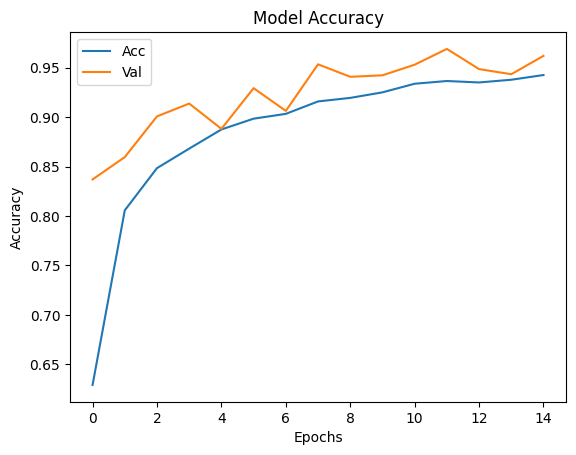

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Acc', 'Val'], loc='upper left')

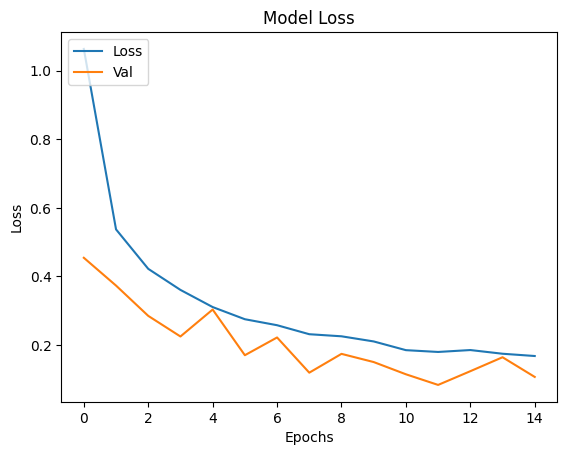

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Val'], loc='upper left')

In [ ]:
def Result(classes):
  values=[]
  max_index = 0
  max_value = 0
  i = 0
  for numbers in classes:
    for number in numbers:
      values.append(number)

  for value in values:
    if value > max_value:
      max_value = value
      max_index = i
    i+=1
  
  return max_index

In [ ]:
savepath = "/content/drive/MyDrive/history"
os.makedirs(savepath, exist_ok=True)

Saving unnamed.jpg to unnamed.jpg
1/1 [==============================] - 0s 20ms/step
[[3.1300146e-16 9.9999738e-01 2.6397699e-06 1.3006996e-08 3.9230084e-11
  1.0986706e-10]]
 is a freshbanana


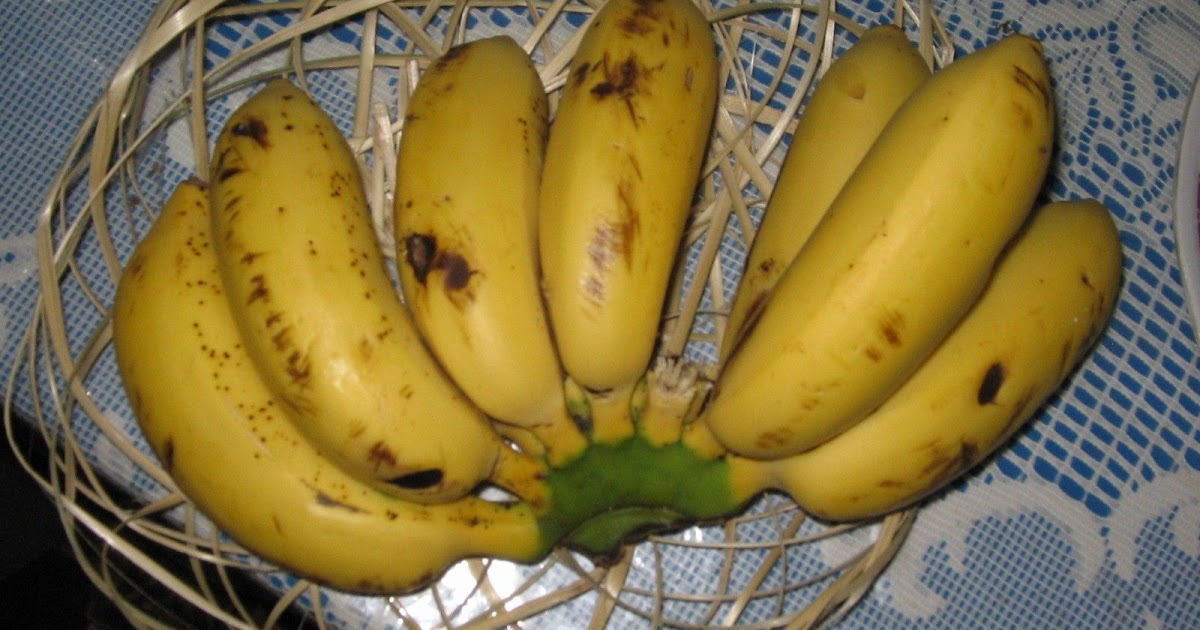

The fruit is 100.000% freshbanana


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
from PIL import Image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  print_image = Image.open(path)
  resized_image = print_image.resize((244, 244), resample=Image.BILINEAR)
  rgb_image = resized_image.convert("RGB")
  normalized_image = np.array(rgb_image) / 255.0
  image_array = np.array(normalized_image)
  image_array = np.expand_dims(normalized_image, axis=0)
  
  classes = model.predict(image_array, batch_size=10)
  print(classes)
  result = Result(classes)

# printing result
  for key, value in labels.items():
    if value == result:
      print(" is a "+ key)
      print_image.show()
      image_name = key + os.path.splitext(fn)[1] 
      save_name = os.path.join(savepath, image_name)
      print_image.save(save_name)

      # Get the index corresponding to the predicted class
      class_index = np.argmax(classes[0])
      predicted_percent = classes[0][class_index] * 100
      print("The fruit is {:.3f}% {}".format(predicted_percent, key))
  
 

In [ ]:
sum = 0
for numbers in classes:
  for i, number in enumerate(numbers):
    print('{}. {:.5f}'.format(i, number))
    sum = sum + number

print(sum)

0. 0.00001
1. 0.00000
2. 0.00869
3. 0.06808
4. 0.00000
5. 0.92322
0.9999999128589967


In [ ]:
RPS_SAVED_MODEL = "rps_saved_model"

In [ ]:
tf.saved_model.save(model, RPS_SAVED_MODEL)

In [ ]:
model.save('model.h5')

In [ ]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['conv2d_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 244, 244, 3)
      name: serving_default_conv2d_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 6)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2023-05-30 16:05:46.979309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'conv2d_input': TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name='conv2d_input')})
{'dense_1': TensorSpec(shape=(None, 6), dtype=tf.float32, name='dense_1')}


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = "converted_model.tflite"

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
shutil.make_archive("rps_saved_model", "zip", "rps_saved_model")

'/content/rps_saved_model.zip'